## CytoTRACE on the entire (130k cells) LARRY dataset

```R

# CytoTRACE R code

library(CytoTRACE)

mat=as.data.frame(t(read.table("/home/mvinyard/notebooks/exploration/LARRY.CytoTRACE/LARRY_GEX.csv", sep=',')))

```

```R

# CytoTRACE R code

library(CytoTRACE)

mat=as.data.frame(t(read.table("/home/mvinyard/notebooks/exploration/LARRY.CytoTRACE/LARRY_GEX.csv", sep=',')))

```

> Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.
>
> Warning message:
The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application. 

```R

results <- CytoTRACE(mat=mat, enableFast = TRUE, ncores = 36)

```

>The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.
>
>CytoTRACE will be run on 131 sub-sample(s) of approximately 999 cells each using 36 / 36 core(s)
>
>Pre-processing data and generating similarity matrix...
>
>Calculating gene counts signature...
>
>Smoothing values with NNLS regression and diffusion...
>
>Calculating genes associated with CytoTRACE...
>
>Done
>
>Warning message:
>
>In CytoTRACE(mat = mat, enableFast = TRUE, ncores = 36) : 1040 genes have zero expression in the matrix and were filtered


```R
# separate objects stored within `results` 

CytoTRACE = as.data.frame(results$CytoTRACE) # dim of cells x 1
CytoTRACErank = as.data.frame(results$CytoTRACErank) # dim of cells x 1
GCS = as.data.frame(results$GCS) # dim of cells x 1
Counts = as.data.frame(results$Counts) # dim of cells x 1
exprMatrix = as.data.frame(results$exprMatrix) # dim of genes x cells
cytoGenes = as.data.frame(results$cytoGenes) # dim of genes x 1
gcsGenes = as.data.frame(results$gcsGenes) # dim of genes x 1
filteredCells = as.data.frame(results$filteredCells) # dim of filtered cells x 1

# write the results to a file

write.table(CytoTRACE, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.CytoTRACE.csv")
write.table(CytoTRACErank, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.CytoTRACErank.csv")
write.table(GCS, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.GCS.csv")
write.table(Counts, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.Counts.csv")
write.table(exprMatrix, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.exprMatrix.csv")
write.table(cytoGenes, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.cytoGenes.csv")
write.table(gcsGenes, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.gcsGenes.csv")
write.table(filteredCells, file = "/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/LARRY.filteredCells.csv")

plotCytoGenes(results, numOfGenes = 10, outputDir="/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/10_")
plotCytoGenes(results, numOfGenes = 25, outputDir="/home/mvinyard/notebooks/exploration/CytoTRACE.LARRY/25_")
plotCytoGenes(results, numOfGenes = 25, outputDir="/home/mvinyard/results/CytoTRACE/CytoTRACE.LARRY/25_")

```

#### Now let's parse the results and integrate them with our pre-existing AnnData object:

In [1]:
%load_ext nb_black

import scdiffeq as sdq

odeint, torch, np, pd, plt, nn, a, os, time, optim, sp, PCA, v = sdq.ut.devlibs()

pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

In [2]:
data = "/home/mvinyard/data/preprocessed/weinreb_2020/author_preprocessed_download"
adata = a.read_h5ad(os.path.join(data, "LARRY.h5ad"))

<IPython.core.display.Javascript object>

In [3]:
adata.obs.head()

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clonal_lineage
0,d6_2_2,GCGTGCAA-AGAAGTTA,6.0,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190,573
1,d6_2_2,AAGGGACC-CTCGATGC,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925,1440
2,d6_2_2,CGTACCGA-AGCGCCTT,6.0,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300,394
3,d6_2_2,CTGAAGGG-AGGAGCTT,6.0,Lin-Kit+Sca1-,Neutrophil,2,1150.028,-2030.369,False
4,d6_2_2,CCGTAGCT-AGGCAGTT,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010,1972


<IPython.core.display.Javascript object>

In [4]:
adata.obs["cytotrace"] = pd.read_csv("./LARRY.CytoTRACE.csv", sep=" ")[
    "results$CytoTRACE"
].values

adata.obs["cytotrace_rank"] = pd.read_csv("./LARRY.CytoTRACErank.csv", sep=" ")[
    "results$CytoTRACErank"
].values

adata.obs["cytotrace_GCS"] = pd.read_csv("./LARRY.GCS.csv", sep=" ")[
    "results$GCS"
].values

cyto_genes = pd.read_csv(
    "./LARRY.cytoGenes.csv", names=["cyto_genes"], sep=" ", index_col=0, skiprows=1
)

gene_id_idx = []
for v in cyto_genes.index.astype(str):
    gene_id_idx.append(v.split("V")[1])

cyto_genes.index = gene_id_idx

adata.var.index = adata.var.index.astype(int)
cyto_genes.index = cyto_genes.index.astype(int) - 1

adata.var = pd.merge(
    adata.var, cyto_genes, left_index=True, right_index=True, how="outer"
)

filt_cells = pd.read_csv("./LARRY.filteredCells.csv", sep=" ")  # no filtered cells

cyto_GCS_genes = pd.read_csv(
    "./LARRY.gcsGenes.csv", names=["GCS_genes"], sep=" ", index_col=0, skiprows=1
)

gene_id_idx = []
for v in cyto_GCS_genes.index.astype(str):
    gene_id_idx.append(v.split("V")[1])

cyto_GCS_genes.index = gene_id_idx
cyto_GCS_genes.index = cyto_GCS_genes.index.astype(int) - 1

adata.var = pd.merge(
    adata.var, cyto_GCS_genes, left_index=True, right_index=True, how="outer"
)

<IPython.core.display.Javascript object>

In [5]:
adata.obsm["X_spring"] = adata.obs[["SPRING-x", "SPRING-y"]].values
adata.obs["lineage_tracing"] = adata.obs["clonal_lineage"] != "False"
adata.obs["clonal_lineage"] = (
    adata.obs["clonal_lineage"].replace("False", int(1e6)).astype(str)
)

adata.write("LARRY.cytotrace_update.h5ad")

... storing 'clonal_lineage' as categorical


<IPython.core.display.Javascript object>

In [6]:
emb_x, emb_y = adata.obsm["X_spring"][:, 0], adata.obsm["X_spring"][:, 1]

<IPython.core.display.Javascript object>

In [7]:
adata.obs.head()

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clonal_lineage,cytotrace,cytotrace_rank,cytotrace_GCS,lineage_tracing
0,d6_2_2,GCGTGCAA-AGAAGTTA,6.0,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190,573,0.998999,999.0,2.694879,True
1,d6_2_2,AAGGGACC-CTCGATGC,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925,1440,0.787788,788.0,2.212651,True
2,d6_2_2,CGTACCGA-AGCGCCTT,6.0,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300,394,0.684685,685.0,1.810267,True
3,d6_2_2,CTGAAGGG-AGGAGCTT,6.0,Lin-Kit+Sca1-,Neutrophil,2,1150.028,-2030.369,1000000,0.339339,340.0,1.675665,False
4,d6_2_2,CCGTAGCT-AGGCAGTT,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010,1972,0.811812,812.0,1.496591,True


<IPython.core.display.Javascript object>

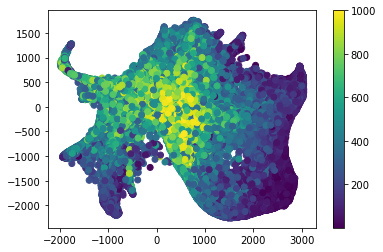

<IPython.core.display.Javascript object>

In [8]:
plt.scatter(emb_x, emb_y, c=adata.obs.cytotrace_rank)
plt.colorbar()

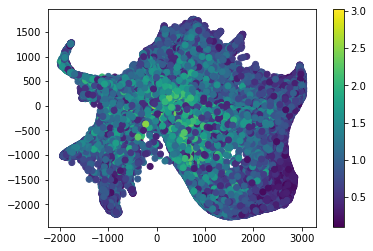

<IPython.core.display.Javascript object>

In [9]:
plt.scatter(emb_x, emb_y, c=adata.obs.cytotrace_GCS)
plt.colorbar()

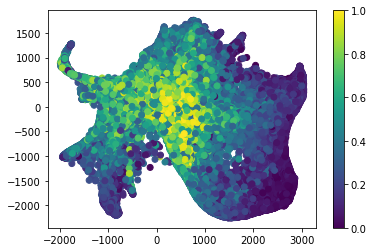

<IPython.core.display.Javascript object>

In [10]:
plt.scatter(emb_x, emb_y, c=adata.obs.cytotrace)
plt.colorbar()

In [18]:
_adata = a.read_csv("./LARRY.exprMatrix.csv", delimiter=" ")
_adata

AnnData object with n_obs × n_vars = 24249 × 130887

<IPython.core.display.Javascript object>